# Decoding population activity

_In this notebook we sample population activity using the analytical model, then analyze the topology and successfully decode orientation using cohomological parametrization_

**Imports**

In [1]:
%matplotlib inline

import sys
import seaborn as sns
import umap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
sys.path.insert(0, './model')
sys.path.insert(0, './numerical')

from sym_model import Population, sigmoid
from model import decoding
from model import persistence
from utils import get_orientation_phase_grid

## Getting the data

**Sampling the activity using the model**

In [2]:
limit = 500
# n_theta, n_phi = 18, 24
n_theta, n_phi = 36, 72
# n_theta, n_phi = 9, 12
step_phi, step_theta = 360 // n_phi, 180 // n_theta
N = 64 # number of cells

In [3]:
grid = get_orientation_phase_grid(step_phi, step_theta)
grid = grid.reshape((-1, 2))
print(grid[0], grid[-1], grid.shape)

[0. 0.] [3.05432619 6.19591884] (2592, 2)


In [4]:
population = Population.sample(8, 8)

In [5]:
len(population.cells)

In [6]:
phi_deg, theta_deg = grid[:, 1] * 180 / np.pi, grid[:, 0] * 180 / np.pi

In [7]:
# res = population.sample_responses(limit, custom_grid=grid, use_sigmoid=False)
# res, phi_deg, theta_deg = res[:, :, 0], res[:, 0, 1], res[:, 0, 2]

In [8]:
res = np.abs(population.response_func(grid[:, 1], grid[:, 0]).swapaxes(0, 1)) * 10

In [9]:
phi_reorder = sorted(list(range(len(phi_deg[:limit]))), key=lambda x: phi_deg[x])
theta_reorder = sorted(list(range(len(theta_deg[:limit]))), key=lambda x: theta_deg[x])

In [10]:
res.shape

In [11]:
res_reshaped = res.reshape((n_phi, n_theta, -1))

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

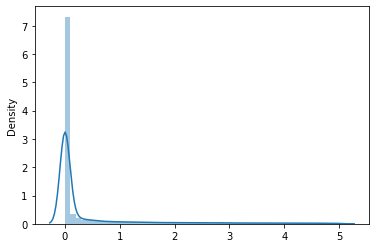

In [12]:
sns.distplot(res.ravel())

## Plotting joint tunings

In [13]:
phase_linspace = np.linspace(0, 360, n_phi)
orientation_linspace = np.linspace(0, 180, n_theta)

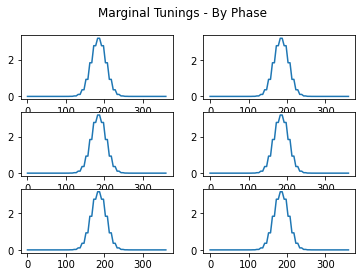

In [14]:
fig, ax = plt.subplots(3, 2)
ax = ax.flatten()
# set title
fig.suptitle('Marginal Tunings - By Phase')
for i in range(6):
    ax[i].plot(phase_linspace, res_reshaped.mean(1)[:, i])

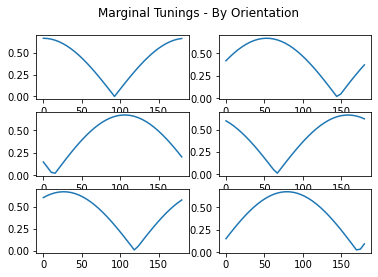

In [15]:
fig, ax = plt.subplots(3, 2)
ax = ax.flatten()
# set title
fig.suptitle('Marginal Tunings - By Orientation')
for i in range(6):
    ax[i].plot(orientation_linspace, res_reshaped.mean(0)[:, i])

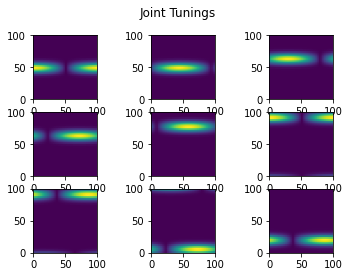

In [16]:
fig, ax = plt.subplots(3, 3)
ax = ax.flatten()
# set title
fig.suptitle('Joint Tunings')
for i in range(9):
    # 100 is for scaling
    ax[i].imshow(res_reshaped[:, :, i * 5], cmap='viridis', extent=[0, 100, 0, 100])

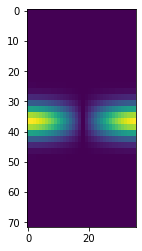

In [17]:
plt.imshow(res_reshaped[:, :, 0], cmap='viridis')

## PCA

In [18]:
res_df = pd.DataFrame(res, columns=['x' + str(i) for i in range(N)])

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns

<AxesSubplot:>

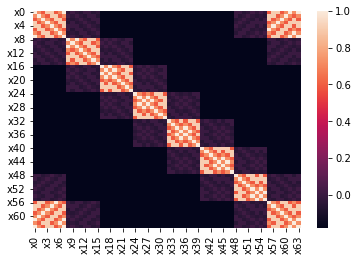

In [20]:
sns.heatmap(res_df.corr())

Let's take 6 components

In [21]:
N_COMP = 7
pca = PCA(n_components=N_COMP)
pca.fit(res_df)
data_pca = pca.transform(res_df)
data_pca = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(N_COMP)])
data_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -2.554005  0.175027  4.007938  0.260290 -1.340241  0.224762 -0.057796
1 -2.550704  0.167788  3.999983  0.247652 -1.335254  0.209454 -0.059524
2 -2.533912  0.159211  3.960137  0.232972 -1.321489  0.192545 -0.059221
3 -2.526949  0.149337  3.942689  0.215383 -1.314273  0.170773 -0.058336
4 -2.537594  0.138229  3.965756  0.194695 -1.318734  0.143174 -0.057358

In [22]:
data_pca.shape

## UMAP decoding

In [23]:
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(data_pca.to_numpy())

In [24]:
# %matplotlib notebook
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1])
# plt.show()

In [25]:
# embedding.shape

## Cohomological decoding

In [26]:
step = 5

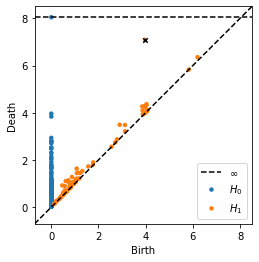

Decoding... done


In [27]:
param_1 = decoding.cohomological_parameterization(data_pca[::step]).to_numpy()

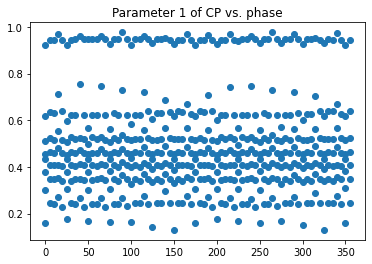

In [28]:
%matplotlib inline
plt.title("Parameter 1 of CP vs. phase")
plt.scatter(phi_deg[::step], param_1)

#### Orientation is decoded:

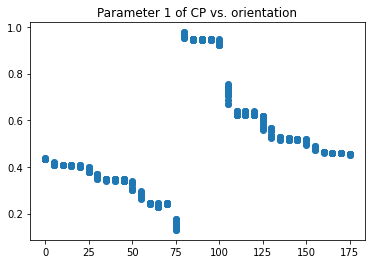

In [29]:
plt.title("Parameter 1 of CP vs. orientation")
plt.scatter(theta_deg[::step], param_1)

In [30]:
data_without_features = decoding.remove_feature(data_pca[::step].to_numpy(), pd.DataFrame(param_1))

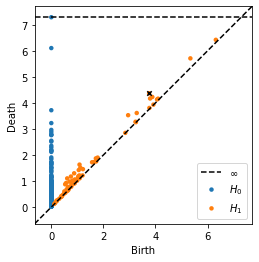

Decoding... done


In [31]:
param_2 = decoding.cohomological_parameterization(
    pd.DataFrame(data_without_features)).to_numpy()

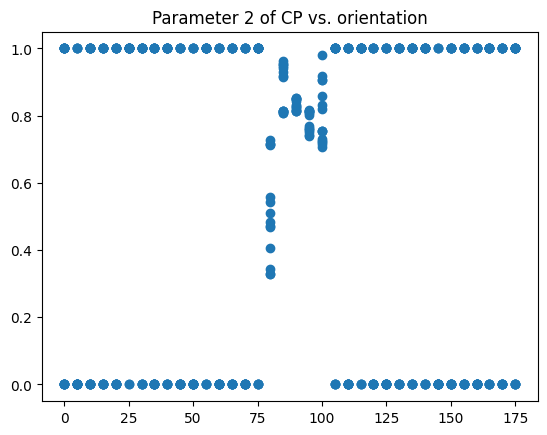

In [32]:
plt.title("Parameter 2 of CP vs. orientation")
plt.scatter(theta_deg[::step], param_2)

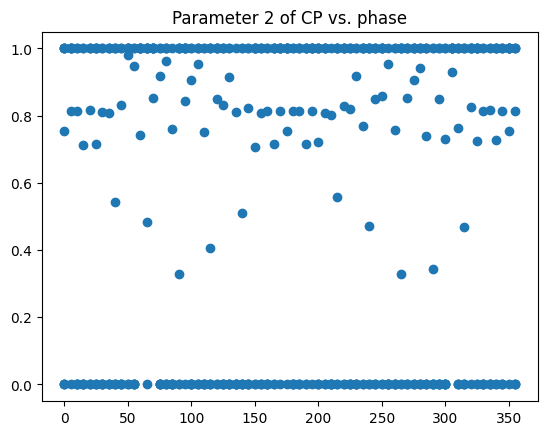

In [33]:
plt.title("Parameter 2 of CP vs. phase")
plt.scatter(phi_deg[::step], param_2)

In [34]:
smooth_par_2 = []
step_deg = 30
for d in range(0, 360, step_deg):
    delta = [param_2[i] for i in range(len(param_2)) if d < phi_deg[i] < d + step_deg]
    if not len(delta):
        smooth_par_2.append(0)
        continue
    smooth_par_2.append(sum(delta) / len(delta))

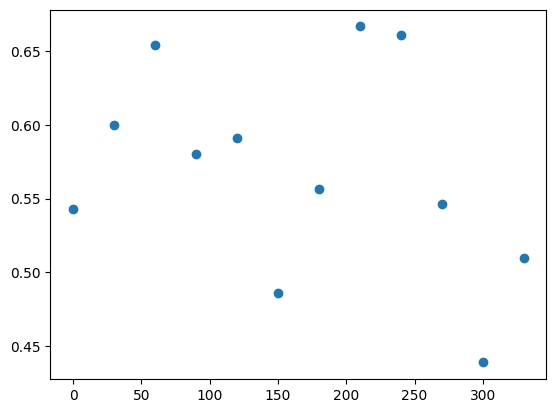

In [35]:
plt.scatter(range(0, 360, step_deg), smooth_par_2)